In [1]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
#plt.rcParams.update({   "text.usetex": True,})
import scipy.interpolate

In [41]:
kvec = np.logspace(1e-3,1e1,20)#
kvec = [1e-3,1e-2,1e-1,1,1e1]
print(kvec)
Omega_M = 0.3
Omega_R = 7e-5
Omega_lambda = 1 - Omega_M - Omega_R

mv_test = 1e3

H0 = 67 / (3*1e5) # i 1/Mpc
cosmo_dict ={'H0':70,  'Omega_cdm':0.2, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
             "m_ncdm":mv_test # massen er givet i eV s' jeg min egen test m_v skal være en faktor  1e-6 mindre
             ,'Omega_ncdm':0.1,
           'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',}

cosmo = Class()
cosmo.set(cosmo_dict)
cosmo.compute()
bg = cosmo.get_background()

pts = cosmo.get_perturbations()['scalar']
print(bg.keys())
pts0=pts[0]
pts_sidst=pts[-1]
print(f"{pts0.keys()=}")
#print( cosmo.Hubble(0))



[0.001, 0.01, 0.1, 1, 10.0]
dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_ncdm[0]', '(.)p_ncdm[0]', '(.)rho_lambda', '(.)rho_ur', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f'])
pts0.keys()=dict_keys(['tau [Mpc]', 'a', 'delta_g', 'theta_g', 'shear_g', 'pol0_g', 'pol1_g', 'pol2_g', 'delta_b', 'theta_b', 'psi', 'phi', 'delta_ur', 'theta_ur', 'shear_ur', 'delta_cdm', 'theta_cdm', 'delta_ncdm[0]', 'theta_ncdm[0]', 'shear_ncdm[0]', 'cs2_ncdm[0]'])


# Neutrino stuff

$T(a) = T_0 * a^{-1}$

$T_0 = 1.9 k$

In [ ]:
# nuetrino stuff

# mass

# mv_test er angivet

# temperature 
# today 
# in kelvin

Tv_k = 1.947
# in MeV
kb = 8.617e-11 # MeV/K

T0 = Tv_k * kb
print(T0)


In [4]:
z = bg["z"]
a = 1/(z+1)
aend = a[-1]
a0 = a[0]

In [5]:
def H(a):
    return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 


def tau_cal(a,y):
    # Vores "tids"-værdi i denne differentialligning er a
    tau = y[0]
    d_tau = 1 / (a ** 2 * H(a))
    return np.array(d_tau)

tau0 = (1/H0) * (Omega_R ** (-0.5)) * a0


sol_tau = sc.solve_ivp(tau_cal,t_span=[a0,aend],y0=[tau0])
tau =sol_tau.y[0]

def a_solve(tau,y):
    a = y[0]
    a_dt = a * a * H(a)
    return [a_dt]

a_solve = sc.solve_ivp(a_solve,t_span=[tau[0],tau[-1]],y0=[a0])
a_tau = a_solve.t
a = a_solve.y[0]
print(a[0],a[-1])
a_interp = scipy.interpolate.interp1d(a_tau,a)
print(a_interp(14550))




9.999999999999987e-15 1.0001652631534843
0.9998270450641846


0.00022795767883904255


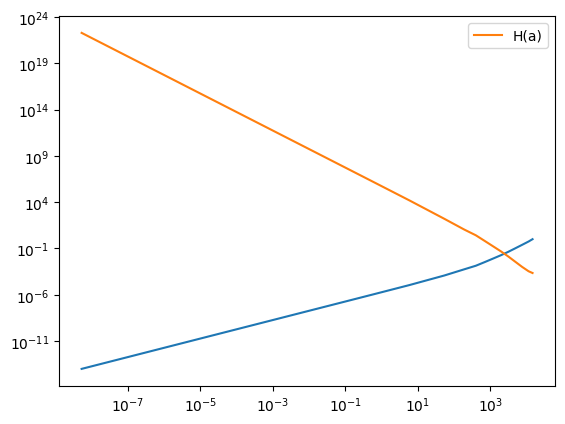

In [6]:
plt.loglog(tau,a_interp(tau))
#print(tau)
print(a_interp(100))
plt.loglog(tau,H(a_interp(tau)),label="H(a)")
plt.legend()

In [7]:
# neutrino temperatur function

def Tv(a):
    return T0 / a # in MeV


def cs(a,mv):
    return 2.680 * Tv(a) / mv

In [8]:
#a0 = a_class[0]

def cb_solve(t,y):    
    delta     = y[0]
    theta     = y[1]
    a = a_interp(t)
    d_delta   = - theta
    nabla2phi = (3/2) * H0*H0 * Omega_M * delta / a
    d_theta   = - a* H(a) * theta - nabla2phi
    
    return [d_delta,d_theta]

#params = [delta0,theta0]
params = [1,0]
t_span = [tau0,tau[-1]]

#print(params,t_span)
sol_cb = sc.solve_ivp(cb_solve,t_span = t_span, y0 = params)
delta = sol_cb.y[0]


mv=0.001


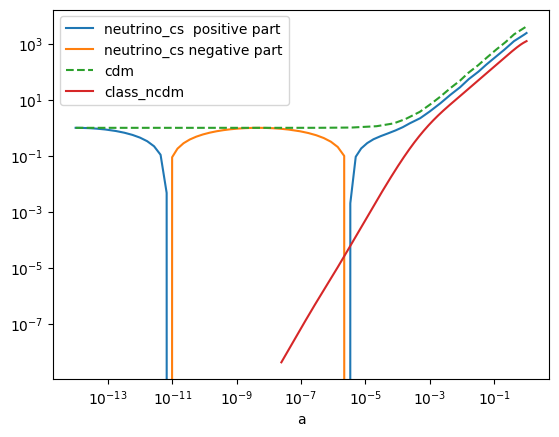

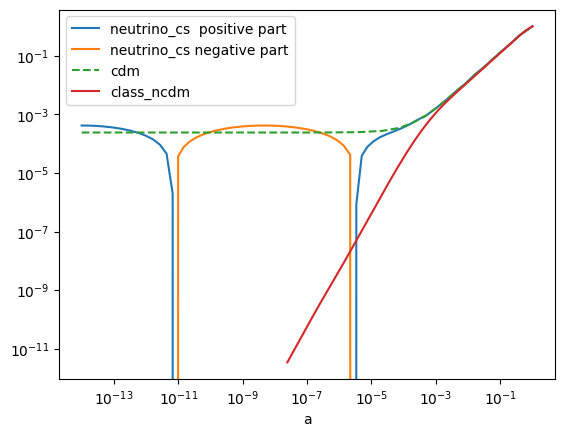

In [59]:
#a0 = a_class[0]
mv = mv_test = 1e3
mv *= 1e-6
print(f"{mv=}")
def cb_solve(t,y,k):    
    delta     = y[0]
    theta     = y[1]
    a = a_interp(t)
    d_delta   = - theta
    nabla2phi = (3/2) * H0*H0 * Omega_M * delta / a
    
    d_theta   = - a* H(a) * theta - nabla2phi + k*k * cs(a,mv)**2 * delta
    
    return [d_delta,d_theta]

#params = [delta0,theta0]
params = [1,0]
t_span = [tau0,tau[-1]]

#print(params,t_span)
sol_cb1 = sc.solve_ivp(cb_solve,t_span = t_span, y0 = params,args=(1,))
delta1 = sol_cb1.y[0]

plt.loglog(a_interp(sol_cb1.t),delta1,label="neutrino_cs  positive part")
plt.loglog(a_interp(sol_cb1.t),-delta1,label="neutrino_cs negative part")
plt.loglog(a_interp(sol_cb.t),np.abs(delta),"--",label="cdm")
plt.xlabel("a")
k_val = 1
plt.loglog(pts[k_val]["a"],np.abs(pts[k_val]["delta_ncdm[0]"]),label="class_ncdm")
plt.legend()

plt.figure(21312)

plt.loglog(a_interp(sol_cb1.t),delta1/delta1[-1],label="neutrino_cs  positive part")
plt.loglog(a_interp(sol_cb1.t),-delta1/delta1[-1],label="neutrino_cs negative part")
plt.loglog(a_interp(sol_cb.t),np.abs(delta)/delta[-1],"--",label="cdm")
plt.xlabel("a")
k_val = 1

plt.loglog(pts[k_val]["a"],np.abs(pts[k_val]["delta_ncdm[0]"]/np.abs(pts[k_val]["delta_ncdm[0]"])[-1]),label="class_ncdm")
plt.legend()


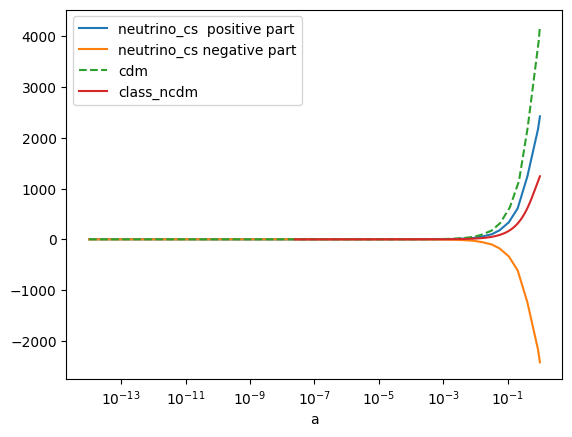

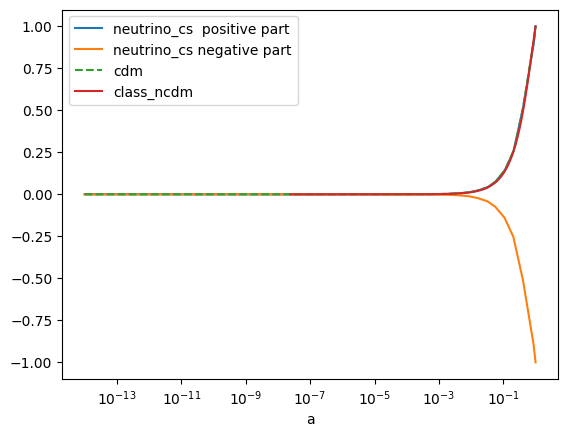

In [61]:

plt.semilogx(a_interp(sol_cb1.t),delta1,label="neutrino_cs  positive part")
plt.semilogx(a_interp(sol_cb1.t),-delta1,label="neutrino_cs negative part")
plt.semilogx(a_interp(sol_cb.t),np.abs(delta),"--",label="cdm")
plt.xlabel("a")
k_val = 1

plt.semilogx(pts[k_val]["a"],np.abs(pts[k_val]["delta_ncdm[0]"]),label="class_ncdm")
plt.legend()
plt.figure(21312)

plt.semilogx(a_interp(sol_cb1.t),delta1/delta1[-1],label="neutrino_cs  positive part")
plt.semilogx(a_interp(sol_cb1.t),-delta1/delta1[-1],label="neutrino_cs negative part")
plt.semilogx(a_interp(sol_cb.t),np.abs(delta)/delta[-1],"--",label="cdm")
plt.xlabel("a")
k_val = 1

plt.semilogx(pts[k_val]["a"],np.abs(pts[k_val]["delta_ncdm[0]"]/np.abs(pts[k_val]["delta_ncdm[0]"])[-1]),label="class_ncdm")
plt.legend()

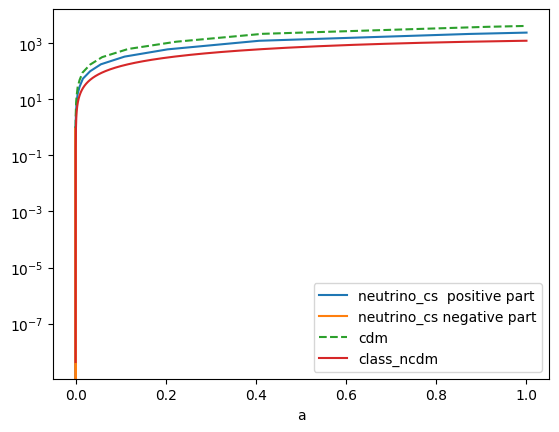

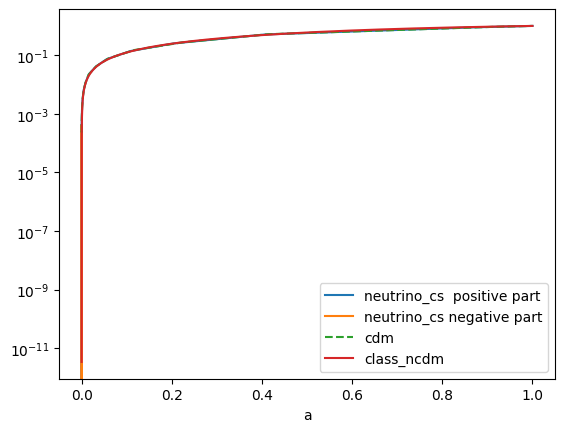

In [62]:

plt.semilogy(a_interp(sol_cb1.t),delta1,label="neutrino_cs  positive part")
plt.semilogy(a_interp(sol_cb1.t),-delta1,label="neutrino_cs negative part")
plt.semilogy(a_interp(sol_cb.t),np.abs(delta),"--",label="cdm")
plt.xlabel("a")
k_val = 1

plt.semilogy(pts[k_val]["a"],np.abs(pts[k_val]["delta_ncdm[0]"]),label="class_ncdm")
plt.legend()
plt.figure(21312)

plt.semilogy(a_interp(sol_cb1.t),delta1/delta1[-1],label="neutrino_cs  positive part")
plt.semilogy(a_interp(sol_cb1.t),-delta1/delta1[-1],label="neutrino_cs negative part")
plt.semilogy(a_interp(sol_cb.t),np.abs(delta)/delta[-1],"--",label="cdm")
plt.xlabel("a")
k_val = 1

plt.semilogy(pts[k_val]["a"],np.abs(pts[k_val]["delta_ncdm[0]"]/np.abs(pts[k_val]["delta_ncdm[0]"])[-1]),label="class_ncdm")
plt.legend()

Text(0.5, 0, 'a')

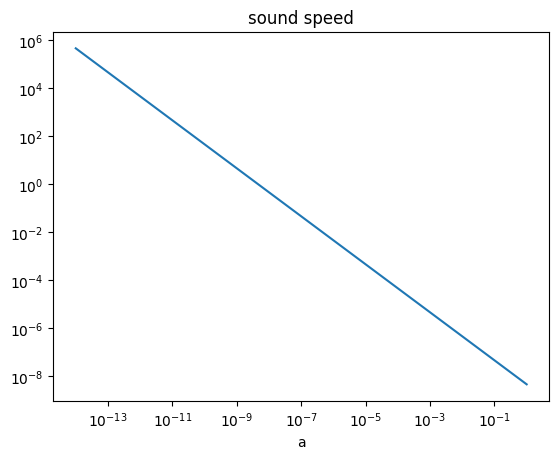

In [11]:
plt.loglog(a,cs(a,mv))
plt.title("sound speed")
plt.xlabel("a")

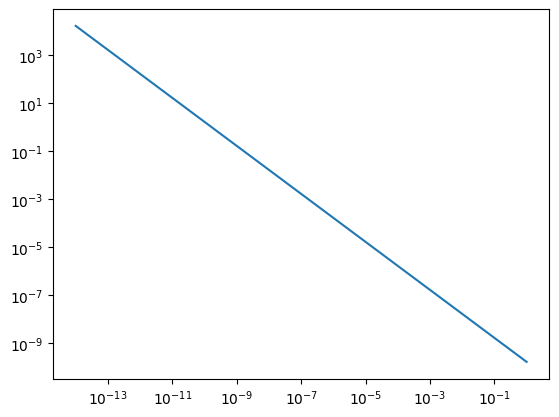

In [12]:
plt.loglog(a,Tv(a))